In [149]:
# Import some modules

import numpy as np
from collections import Counter # to get the most common label in a given label vector
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, BoundaryNorm

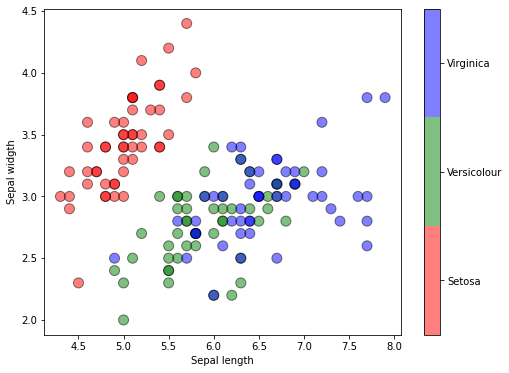

In [146]:
# Import iris data and visualize them

data = datasets.load_iris()
X = data.data
y = data.target

# plot the first two features
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

col_dict={0:"red",
          1:"green",
          2:"blue"}


labels = np.array(["Setosa","Versicolour","Virginica"])
len_lab = len(labels)

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])


norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])


fig = plt.figure(1, figsize=(8, 6))
plt.clf()

# plot the training data points
p = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, norm = norm, edgecolor='k', alpha=0.5, s=100)
plt.xlabel("Sepal length")
plt.ylabel("Sepal widgth")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(p, format=fmt, ticks=tickz)
plt.show()





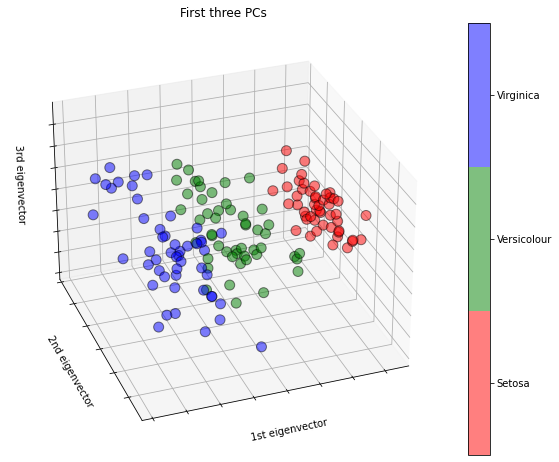

In [147]:
# Plot the first three principal components of the input feature matrix
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110, auto_add_to_figure=False)
fig.add_axes(ax)
PCAs = PCA(n_components=3).fit_transform(X)



p = ax.scatter(PCAs[:, 0],
          PCAs[:, 1],
          PCAs[:, 2],
          c=y,
          cmap=cm,
          norm = norm,
          edgecolor="k",
          s =100,
          alpha = 0.5)

ax.set_title("First three PCs")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(p, format=fmt, ticks=tickz)


plt.show()






In [181]:
# Helper function to compute the entropy of a given set of class observations

def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    ps = counts/len(y)
    #hist = np.bincount(y)
    #ps = hist/len(y)
    return  -np.sum(ps*np.log2(ps))

#print(entropy(y))




# Define a helper class 'Node' to characterize a node:
# if the node is not a leaf, we need [feature, threshold, left_child, right_child]
# and if the node is a leaf, then we need the class value for it only:
#     that way we have to input the parameter through keywork ('value')

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    # define a helper function to identify a leaf node (if the keywork parameter 'value' is passed on)
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    
    # min_samples_split: minimum number of samples in a node to further split the tree  
    # n_feats: greedy search (splitting) over n_feats number of features
    #       here ALL features, but we can do a subset as in Random Forest
    # root: the root (original node) at which to start traversing the tree
    
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
    
    
    # grow the tree
    def fit(self, X, y):
        
        # take the maximum number of features if n_feats is not specified
        # Also check if n_feats is not larger the actual number of features
        self.n_feats = X.shape[1] if not self.n_feats else min(X.shape[1], self.n_feats)
        self.root = self._grow_tree(X, y)
    
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # check for stopping criteria including:
        #   1. maximum depth
        #   2. number of samples in the node
        #   3. number of distinct classes in the node (if 1, no need for further splitting)
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_labels ==1):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # choose a random set of features
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)
        
        # greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feat, best_thresh, left, right)
        
        
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self._information_gain(y,X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh
    
    
    def _information_gain(self, y, X_column, split_thresh):
        # parent entropy
        parent_entropy = entropy(y)
        
        # generate a split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        
        # check if there are classes in the splitted branches, if not, return IG of 0
        if len(left_idxs) == 0 or len(right_idxs)==0:
            return 0
        
        # weighted average of child entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        
        # return information gain
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        ig = parent_entropy - child_entropy
        return ig
    
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    
    def _most_common_label(self, y):
        counter = Counter(y)
         # this gives a list of tuples, we want the first value (class label) of the most frequent class
        most_common = counter.most_common(1)[0][0]
        return most_common
             
        
    # traverse the tree
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [175]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred)/len(y_true)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy(y_pred, y_test))

0.9666666666666667
